## Time-series based analysis of Earthquake Risk Factors

### Part 4: Performing linear regression

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score




import pickle

### Part 2.1: Prepping Loma Prieta EQ's:

In [2]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_lp_eq = pd.read_csv(file_path)
df_lp_eq.drop(columns = "Unnamed: 0", inplace = True)

df_lp_eq["time"] = pd.to_datetime(df_lp_eq["time"])

df_lp_eq.sort_values(by = "time", inplace=True)


df_lp_eq.reset_index(drop = True, inplace=True)
df_lp_eq.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_lp_eq.head()

,time,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth
0,1989-10-09 01:38:42.380,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805
1,1989-10-09 02:07:50.370,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137
2,1989-10-09 02:15:01.850,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826
3,1989-10-09 03:54:18.030,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985
4,1989-10-09 04:18:04.350,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540


In [3]:
df_lp_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1271 non-null   datetime64[ns]
 1   mag        1271 non-null   float64       
 2   sig        1271 non-null   int64         
 3   dmin       1153 non-null   float64       
 4   rms        1270 non-null   float64       
 5   gap        1270 non-null   float64       
 6   magType    1271 non-null   object        
 7   longitude  1271 non-null   float64       
 8   latitude   1271 non-null   float64       
 9   depth      1271 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 99.4+ KB


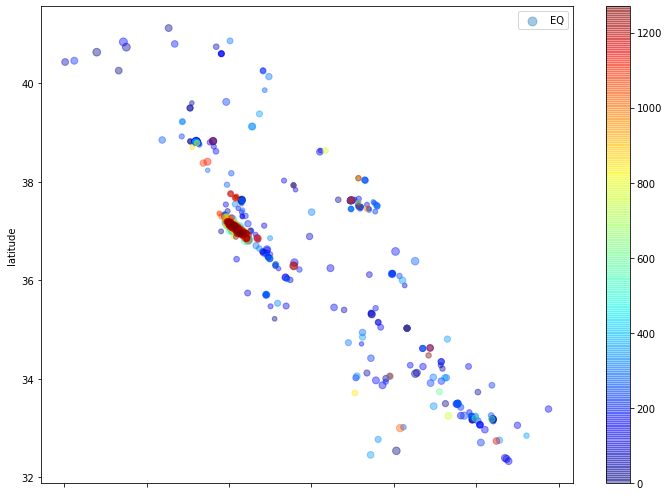

In [4]:
df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()

plt.tight_layout()

## Finding the main failure time:

In [5]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float
import datetime as dt

epoch = dt.datetime(1970, 1, 1)

time = []
for t in [(d - epoch).total_seconds() for d in df_lp_eq["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_lp_eq["time_seconds"] = time

failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

df_lp_eq["time_to_failure_sec"] = np.array(df_lp_eq["time_seconds"]) - np.array(failure_event["time_seconds"])


In [6]:
df_lp_eq.drop(columns=["time", "time_seconds"], inplace=True)


df_lp_eq.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805,-771932.81
1,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137,-770184.82
2,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826,-769753.34
3,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985,-763797.16
4,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540,-762370.84


Checking if failure is correctly zero:

In [7]:
failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

failure_event

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
356,6.9,1602,0.008108,0.08,89.0,mh,-121.879833,37.036167,17.214,0.0


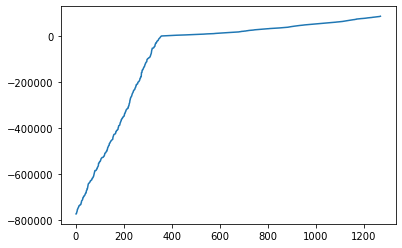

In [8]:
plt.plot(df_lp_eq["time_to_failure_sec"])

### Part 2.2: Prepping Parkfield EQ's:

In [9]:
file_path = "../datasets/" + "eq_parkfield" + "_clean" + ".csv"

df_pf_eq = pd.read_csv(file_path)
df_pf_eq.drop(columns = "Unnamed: 0", inplace = True)

df_pf_eq["time"] = pd.to_datetime(df_pf_eq["time"])

df_pf_eq.sort_values(by = "time", inplace=True)


df_pf_eq.reset_index(drop = True, inplace=True)
df_pf_eq.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_pf_eq.head()

,time,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth
0,2004-09-20 15:59:25.390,2.38,87,0.02523,0.0600,35.00,md,-121.548667,36.825333,5.964
1,2004-09-20 15:59:35.318,1.60,39,0.07000,0.1135,75.17,ml,-118.653400,38.024800,7.000
2,2004-09-20 16:01:44.638,1.10,19,0.03600,0.1353,101.52,ml,-118.691400,37.999300,2.800
3,2004-09-20 16:02:06.359,1.00,15,0.05000,0.1561,94.73,mb,-118.670900,38.004100,3.600
4,2004-09-20 16:05:18.108,1.20,22,0.04200,0.0586,96.83,mb,-118.686100,38.003400,5.400


In [10]:
df_pf_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       2000 non-null   datetime64[ns]
 1   mag        2000 non-null   float64       
 2   sig        2000 non-null   int64         
 3   dmin       1999 non-null   float64       
 4   rms        2000 non-null   float64       
 5   gap        2000 non-null   float64       
 6   magType    2000 non-null   object        
 7   longitude  2000 non-null   float64       
 8   latitude   2000 non-null   float64       
 9   depth      2000 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 156.4+ KB


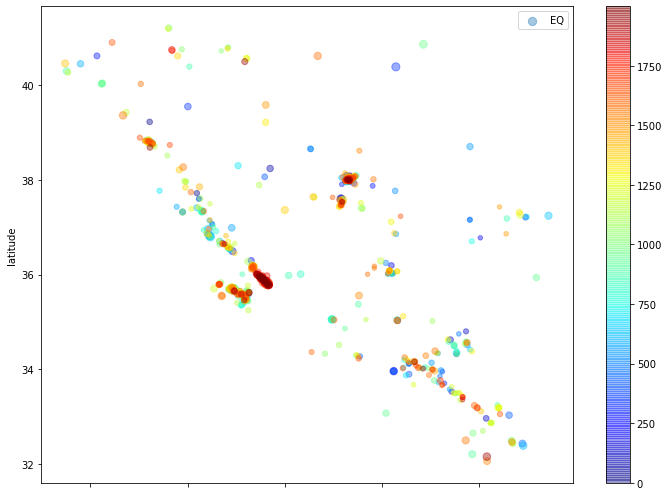

In [11]:
df_pf_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_pf_eq['mag']/0.05, label="EQ",
    c=df_pf_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()

plt.tight_layout()

## Finding the main failure time:

In [12]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float
import datetime as dt

epoch = dt.datetime(1970, 1, 1)

time = []
for t in [(d - epoch).total_seconds() for d in df_pf_eq["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_pf_eq["time_seconds"] = time

failure_event = df_pf_eq[df_pf_eq["mag"] == df_pf_eq["mag"].max()]

df_pf_eq["time_to_failure_sec"] = np.array(df_pf_eq["time_seconds"]) - np.array(failure_event["time_seconds"])


In [13]:
df_pf_eq.drop(columns=["time", "time_seconds"], inplace=True)


df_pf_eq.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,2.38,87,0.02523,0.0600,35.00,md,-121.548667,36.825333,5.964,-695758.860
1,1.60,39,0.07000,0.1135,75.17,ml,-118.653400,38.024800,7.000,-695748.932
2,1.10,19,0.03600,0.1353,101.52,ml,-118.691400,37.999300,2.800,-695619.612
3,1.00,15,0.05000,0.1561,94.73,mb,-118.670900,38.004100,3.600,-695597.891
4,1.20,22,0.04200,0.0586,96.83,mb,-118.686100,38.003400,5.400,-695406.142


Checking if failure is correctly zero:

In [14]:
failure_event = df_pf_eq[df_pf_eq["mag"] == df_pf_eq["mag"].max()]

failure_event

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
1694,5.97,1280,0.01622,0.04,26.0,mw,-120.366,35.818167,8.136,0.0


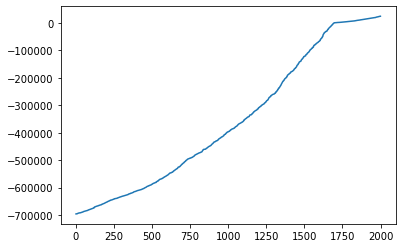

In [15]:
plt.plot(df_pf_eq["time_to_failure_sec"])

# Building the model:

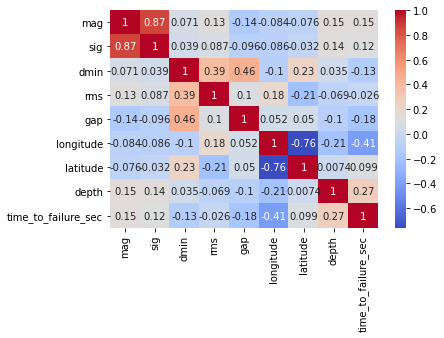

In [16]:
import seaborn as sns

sns.heatmap(df_lp_eq.corr(), annot=True, cmap='coolwarm')

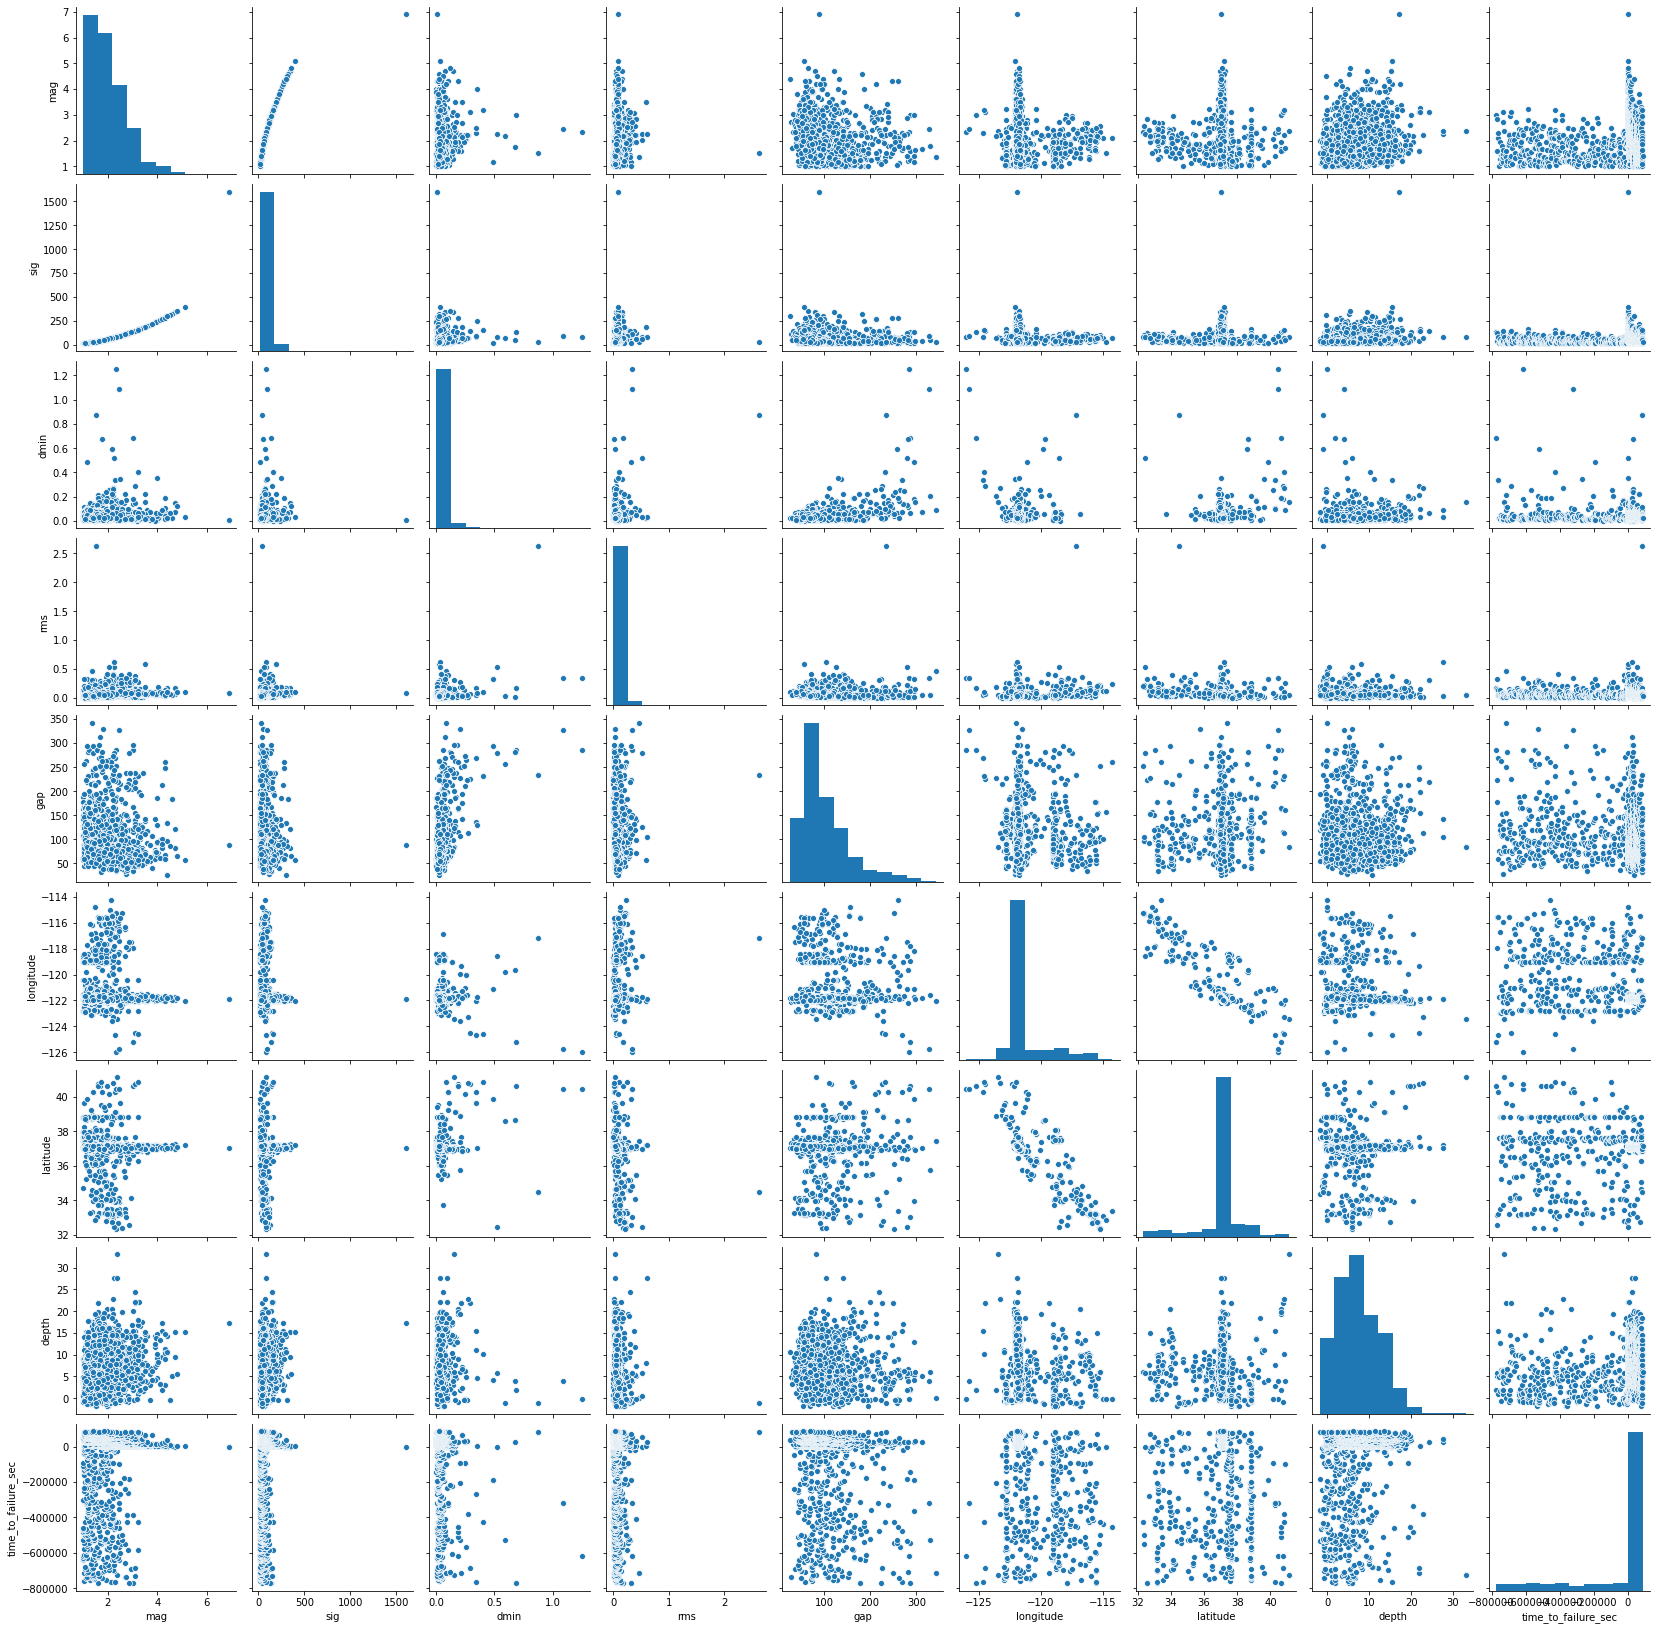

In [17]:
sns.pairplot(df_lp_eq)

## LINE Assumptions
The assumptions necessary to conduct a proper linear regression are easily remembered by the "LINE" acronym:

* L - Linearity: there is a linear relationship between x and y (fix: apply non-linear transformation)
* I - Independence of residuals (usually assumed)
* N - Normality: residuals are normally distributed (fix: log y variable)
* E - Equality of variance: residuals have constant variance (fix: check outliers, non-linear transformation)

In [18]:
# Step 3: Instantiate the model
lr = LinearRegression()
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = df_lp_eq[["mag", "sig", "depth"]]

# We need a y vector that is length n
y = df_lp_eq["time_to_failure_sec"]

lr.fit(X, y)

y_pred = lr.predict(X)

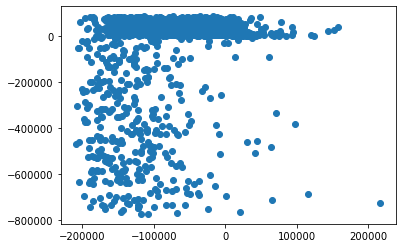

In [19]:
plt.scatter(y_pred, y)

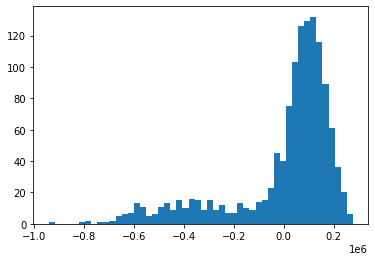

In [20]:
# Creat residuals
resids = y - y_pred
# N assumption:
plt.hist(resids, bins=50);

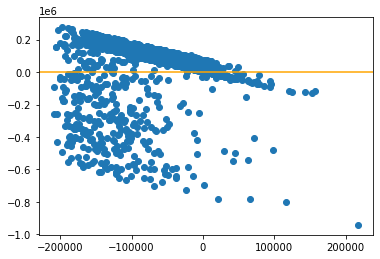

In [21]:
# L and E assumption
# our actual residuals
plt.scatter(y_pred, resids)
plt.axhline(0, color='orange');

In [22]:
lr.score(X, y)

0.0839546061493135

In [23]:
# Via sklearn.metrics
from sklearn import metrics


metrics.mean_absolute_error(y, y_pred)

156681.36480384727

In [24]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     time_to_failure_sec   R-squared:                       0.084
Model:                             OLS   Adj. R-squared:                  0.082
Method:                  Least Squares   F-statistic:                     38.71
Date:                 Sat, 05 Sep 2020   Prob (F-statistic):           6.22e-24
Time:                         20:38:12   Log-Likelihood:                -17399.
No. Observations:                 1271   AIC:                         3.481e+04
Df Residuals:                     1267   BIC:                         3.483e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.409e+05   2.43e+04     -9.926      0.000   -2.88e+05   -1.93e+05
mag         4.515e+04   1.63e+04      2.769      0.006    1.32e+04    7.71e+04
sig         -161.7685    174.522     -0.927      0.354    -504.152     180.615
depth       1.105e+04   1189.498      9.286      0.000    8711.872    1.34e+04
==============================================================================
Omnibus:                      358.829   Durbin-Watson:                   0.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              759.041
Skew:                          -1.631   Prob(JB):                    1.50e-165
Kurtosis:                       4.921   Cond. No.                         470.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Trying out polynomial features : 

In [25]:
features = ["mag", "sig", "depth"]
X = df_lp_eq[features]
y = df_lp_eq['time_to_failure_sec']

In [26]:
poly = PolynomialFeatures(include_bias=False)

In [27]:
X_poly = poly.fit_transform(X)

In [28]:
cross_val_score(lr, X_poly, y, cv=5).mean()

-3871.9638026547536

In [29]:
df = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))
df.head()

,mag,sig,depth,mag^2,mag sig,mag depth,sig^2,sig depth,depth^2
0,3.00,138.0,1.805,9.0000,414.00,5.41500,19044.0,249.090,3.258025
1,1.60,39.0,5.137,2.5600,62.40,8.21920,1521.0,200.343,26.388769
2,2.85,125.0,5.826,8.1225,356.25,16.60410,15625.0,728.250,33.942276
3,2.11,68.0,0.985,4.4521,143.48,2.07835,4624.0,66.980,0.970225
4,2.29,81.0,15.540,5.2441,185.49,35.58660,6561.0,1258.740,241.491600


In [30]:
df_lp_eq.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805,-771932.81
1,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137,-770184.82
2,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826,-769753.34
3,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985,-763797.16
4,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540,-762370.84


In [31]:
df_merged = pd.concat([df, df_lp_eq], axis=1, sort=False)


df_merged.head()

,mag,sig,depth,mag^2,mag sig,mag depth,sig^2,sig depth,depth^2,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.00,138.0,1.805,9.0000,414.00,5.41500,19044.0,249.090,3.258025,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805,-771932.81
1,1.60,39.0,5.137,2.5600,62.40,8.21920,1521.0,200.343,26.388769,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137,-770184.82
2,2.85,125.0,5.826,8.1225,356.25,16.60410,15625.0,728.250,33.942276,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826,-769753.34
3,2.11,68.0,0.985,4.4521,143.48,2.07835,4624.0,66.980,0.970225,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985,-763797.16
4,2.29,81.0,15.540,5.2441,185.49,35.58660,6561.0,1258.740,241.491600,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540,-762370.84


In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mag                  1271 non-null   float64
 1   sig                  1271 non-null   float64
 2   depth                1271 non-null   float64
 3   mag^2                1271 non-null   float64
 4   mag sig              1271 non-null   float64
 5   mag depth            1271 non-null   float64
 6   sig^2                1271 non-null   float64
 7   sig depth            1271 non-null   float64
 8   depth^2              1271 non-null   float64
 9   mag                  1271 non-null   float64
 10  sig                  1271 non-null   int64  
 11  dmin                 1153 non-null   float64
 12  rms                  1270 non-null   float64
 13  gap                  1270 non-null   float64
 14  magType              1271 non-null   object 
 15  longitude            1271 non-null   f